# Storytelling workshop 2019

## Topics considered:

http://www.visionandlanguage.net/workshop2019/cfp.html

1. **`Character relationships`**
2. ~~Augmenting human storytelling~~ (overhead of involving humans)
3. ~~Story concept detection and annotation~~ (publication exists)
4. Affect and emotion in stories

## Premise architectures:

- Adversarial reward learning: https://arxiv.org/pdf/1804.09160.pdf
- Hirarchical-decoder models for topically coherent storytelling: https://arxiv.org/pdf/1805.08191.pdf

## Rudimentary plan (from sync-ups):

1. Extract all plausible characters from VIST dataset
2. Design an architecture (making use of the idea from the above premise architectures) which accepts characters as context for story generation
3. Analyze such generated stories for ~~correlation amongst characters~~ (something close!)

<u>Example:</u>

$B \rightarrow \text{Bride}, G \rightarrow \text{Groom}$

|    expected result    |     actual result     |  comment  |
|:---------------------:|:---------------------:|:---------:|
| $\bar{B}\land\bar{G}$ |       $B\lor G$       |    bad    |
|       $B\lor G$       | $\bar{B}\land\bar{G}$ |    bad    |
| $\bar{B}\land\bar{G}$ |       $B\land G$      |  very bad |
|       $B\land G$      | $\bar{B}\land\bar{G}$ |  very bad |
|       $B\land G$      |    $B\land\bar{G}$    |    good   |
|       $B\land G$      |       $B\land G$      | very good |
|        $\vdots$       |          $\vdots$     | $\vdots$  |

## Extracting characters from VIST:

Methods to try:

- $X$ ~~[Object detection](#Object-detection)~~ (only classifies as certain predefined classes `person/sandwich ...`)
- $\checkmark$ [Using nltk](#Using-nltk)

### Object detection

In [3]:
!pip install --user https://github.com/OlafenwaMoses/ImageAI/releases/download/2.0.2/imageai-2.0.2-py3-none-any.whl 

    100% |████████████████████████████████| 153kB 409kB/s 


In [1]:
from imageai.Detection import ObjectDetection

import pickle
import json
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath('../../resources/resnet50_coco_best_v2.0.1.h5')
detector.loadModel()

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
def get_objects(image_path):
    try:
        detections = detector.detectObjectsFromImage(input_image=image_path)
    except:
        return []
    return [_object['name'] for _object in detections]

In [4]:
def iterate_sequences(anns, img_dir, save_as):
    all_seq_objects = {}
    cur_seq_objects = []

    for idx, ann in enumerate(anns):
        img_name = ann[0]['photo_flickr_id']
        if os.path.exists(os.path.join(img_dir, img_name + '.jpg')):
            img_path = os.path.join(img_dir, img_name + '.jpg')
        elif os.path.exists(os.path.join(img_dir, img_name + '.png')):
            img_path = os.path.join(img_dir, img_name + '.png')
        else:
            print('bad image!')
            continue

        cur_seq_objects.append(get_objects(img_path))
        if idx < 5:
            print(cur_seq_objects[len(cur_seq_objects) - 1])
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.show()

        if (idx + 1) % 5 == 0:
            all_seq_objects[ann[0]['story_id']] = cur_seq_objects
            cur_seq_objects = []
            if (idx + 1) % 2000 == 0:
                print(f'{(idx + 1) / 5} sequences complete!')
            
    print('objects detection complete!')
    output = open(save_as, 'wb')
    pickle.dump(all_seq_objects, output)
    output.close()
    print(f'saved to {save_as}')

In [5]:
def main(images_dir, anns_path, save_as):
    with open(anns_path) as raw_data:
        json_data = json.load(raw_data)
        anns = json_data['annotations']
    
    print(f'number of annotations: {len(anns)}')
    iterate_sequences(anns, images_dir, save_as)

In [ ]:
images_dir = '/u/74/surikua1/unix/code/visual-storytelling/resources/filtered_validate'
anns_path = '/u/74/surikua1/unix/code/visual-storytelling/resources/sis/val.story-in-sequence.json'
save_as = '/u/74/surikua1/unix/code/visual-storytelling/resources/objects_val.pkl'

main(images_dir, anns_path, save_as)

### Using nltk

<u><b>Process:</b></u>

- ~~sentence tokenization~~ (already seperate sentences)

  $\downarrow$
- word tokenization
  
  $\downarrow$
- parts of speech tagging
  
  $\downarrow$
- ~~chunking (named entity recognition)~~ (not required as the textual `VIST` data is already processed using CORE-NLP)

  $\downarrow$
- extraction and mapping of nouns (common/plural) with `VIST` story-ids


In [2]:
import nltk
from nltk.corpus import wordnet as wn
import stanfordnlp as snlp

In [3]:
nltk.help.upenn_tagset(tagpattern='N')

NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...
NNP: noun, proper, singular
    Motown Venneboerger Czestochwa Ranzer Conchita Trumplane Christos
    Oceanside Escobar Kreisler Sawyer Cougar Yvette Ervin ODI Darryl CTCA
    Shannon A.K.C. Meltex Liverpool ...
NNPS: noun, proper, plural
    Americans Americas Amharas Amityvilles Amusements Anarcho-Syndicalists
    Andalusians Andes Andruses Angels Animals Anthony Antilles Antiques
    Apache Apaches Apocrypha ...
NNS: noun, common, plural
    undergraduates scotches bric-a-brac products bodyguards facets coasts
    divestitures storehouses designs clubs fragrances averages
    subjectivists apprehensions muses factory-jobs ...


In [4]:
example = 'mom decided to take her daughter and family to the carnival in location.'

In [5]:
words = nltk.word_tokenize(example)
print(f'{len(words)} words\n{words}')

14 words
['mom', 'decided', 'to', 'take', 'her', 'daughter', 'and', 'family', 'to', 'the', 'carnival', 'in', 'location', '.']


In [6]:
pos_tags = nltk.pos_tag(words)
print(f'{len(words)} words tagged\n{pos_tags}')

14 words tagged
[('mom', 'NN'), ('decided', 'VBD'), ('to', 'TO'), ('take', 'VB'), ('her', 'PRP$'), ('daughter', 'NN'), ('and', 'CC'), ('family', 'NN'), ('to', 'TO'), ('the', 'DT'), ('carnival', 'NN'), ('in', 'IN'), ('location', 'NN'), ('.', '.')]


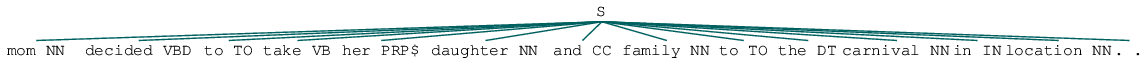

In [18]:
nltk.chunk.ne_chunk(pos_tags)

In [7]:
nouns = [pos_tags[idx] for idx in range(len(pos_tags)) if pos_tags[idx][1].startswith('N')]
nouns

[('mom', 'NN'),
 ('daughter', 'NN'),
 ('family', 'NN'),
 ('carnival', 'NN'),
 ('location', 'NN')]

These nouns need to be **further filtered** for common nouns `(mom, boy, ... )`

In [40]:
for synset in wn.synsets('father'):
    print("\tLemma: {}".format(synset.name()))
    print("\tDefinition: {}".format(synset.definition()))
    print("\tExample: {}".format(synset.examples()))
    print('\t', synset.instance_hypernyms, '\n')

	Lemma: father.n.01
	Definition: a male parent (also used as a term of address to your father)
	Example: ['his father was born in Atlanta']
	 <bound method _WordNetObject.instance_hypernyms of Synset('father.n.01')> 

	Lemma: forefather.n.01
	Definition: the founder of a family
	Example: ['keep the faith of our forefathers']
	 <bound method _WordNetObject.instance_hypernyms of Synset('forefather.n.01')> 

	Lemma: father.n.03
	Definition: `Father' is a term of address for priests in some churches (especially the Roman Catholic Church or the Orthodox Catholic Church); `Padre' is frequently used in the military
	Example: []
	 <bound method _WordNetObject.instance_hypernyms of Synset('father.n.03')> 

	Lemma: church_father.n.01
	Definition: (Christianity) any of about 70 theologians in the period from the 2nd to the 7th century whose writing established and confirmed official church doctrine; in the Roman Catholic Church some were later declared saints and became Doctor of the Church; the 

In [100]:
synset = wn.synsets('bride')[0]
lemma = synset.name()
person = wn.synset(lemma).lowest_common_hypernyms(wn.synset('person.n.01'))[0].name()
animal = wn.synset(lemma).lowest_common_hypernyms(wn.synset('animal.n.01'))[0].name()
if 'person' in person:
    print('character detected!')
elif 'animal' in animal:
    print('character detected!')
else:
    print('misc...')

character detected!


## Analysis of detected characters:

In [1]:
import pickle

def read_characters(filename):
    with open(filename, mode='rb') as file:
        characters = pickle.load(file)
    
    file.close()
    return characters

In [2]:
characters_train = read_characters('../../resources/sis/characters_train.pkl')
characters_val = read_characters('../../resources/sis/characters_val.pkl')
characters_test = read_characters('../../resources/sis/characters_test.pkl')

print(f'{len(characters_train), len(characters_val), len(characters_test)} train, val, test sequences')

(40155, 4990, 5055) train, val, test sequences


In [3]:
def filter_characters(characters, split_name):
    print(f'\n{split_name} split:\n')
    characters_filtered = {}
    printing = 0
    for story_id, story in characters.items():
        characters_now = []
        for sentence in story:
            if len(sentence):
                characters_now.extend(sentence)

        if len(characters_now) >= 2:
            characters_filtered[story_id] = story
            if printing < 5:
                print(f'\t{story_id}: {characters_now}')
                printing += 1

    return characters_filtered

In [4]:
from operator import itemgetter

def characters_frequency(characters):
    frequency = {}
    for story_id, story in characters.items():
        for sentence in story:
            for character in sentence:
                if character in frequency:
                    frequency[character] += 1
                else:
                    frequency[character] = 1
                    
                        
    return sorted(frequency.items(), key=itemgetter(1), reverse=True)

In [5]:
from operator import itemgetter

def frequent_pairs(characters):
    pairs_frequency = {}
    for _, story in characters.items():
        all_characters = []
        for sentence in story:
            all_characters.extend(sentence)
        
        distinct = sorted(list(set(all_characters)))
        for idx1 in range(len(distinct)):
            for idx2 in range(idx1 + 1, len(distinct)):
                    pair = (distinct[idx1], distinct[idx2])
                    if pair not in pairs_frequency:
                        pairs_frequency[pair] = 1
                    else:
                        pairs_frequency[pair] += 1
        
    return sorted(pairs_frequency.items(), key=itemgetter(1), reverse=True)

### Training split

In [6]:
characters_train_filtered = filter_characters(characters_train, 'training')
print(f'\n{len(characters_train_filtered)} training split stories with more than 2 characters')
characters_train_frequency = characters_frequency(characters_train_filtered)
print(f'\n{len(characters_train_frequency)} distinct characters in filtered training split')
character_pairs_train_frequency = frequent_pairs(characters_train_filtered)
print(f'\n{len(character_pairs_train_frequency)} pairs in training split')


training split:

	2: ['friend', 'friend']
	13: ['photographer', 'friend', 'friend', 'friends', 'photographers']
	16: ['deer', 'hikers']
	22: ['child', 'child']
	23: ['sister', 'sister']

9836 training split stories with more than 2 characters

1333 distinct characters in filtered training split

6758 pairs in training split


In [15]:
characters_train_frequency_sampled = [('wife', 688),('girls', 610),('daughter', 598),('boy', 524),('students', 498),('animals', 314),('bunny', 109),('sheep', 44),('panda', 43),('tiger', 34),('camel', 25),('giraffe', 20),('maids', 20),('performer', 19),('reporters', 19),('santa', 19),('dinosaur', 19),('dolphins', 19),('deer', 17),('dads', 17),('waiter', 17),('seagull', 17),('giraffes', 17),('cheerleader', 17),('scientist', 17),('nephews', 16),('keyboardist', 14),('actor', 14),('fishermen', 14),('ranger', 14)]

In [18]:
character_pairs_train_frequency_sampled = [(('player', 'singer'), 15),(('buddy', 'friends'), 15),(('cheerleaders', 'players'), 15),(('friends', 'winner'), 15),(('ladies', 'lady'), 15),(('girl', 'mommy'), 5),(('employees', 'workers'), 5),(('cheerleaders', 'dancers'), 5),(('children', 'sisters'), 5),(('child', 'someone'), 5),(('nobody', 'sister'), 5),(('firefighter', 'firefighters'), 4),(('grandson', 'wife'), 4),(('friends', 'hubby'), 4),(('brother', 'fiance'), 4),(('aunt', 'bridesmaids'), 4),(('girl', 'photographers'), 2),(('friends', 'penguins'), 2),(('beast', 'dad'), 2),(('friends', 'hatter'), 2),(('friend', 'surfer'), 2),(('crocodile', 'koala'), 2),(('friends', 'simpson'), 2),(('mom', 'somebody'), 2),(('sister', 'somebody'), 2),(('boys', 'cousin'), 2),(('artist', 'daddy'), 2),(('daughter', 'flamingos'), 2),(('camel', 'rhino'), 2),(('dad', 'owl'), 2)]

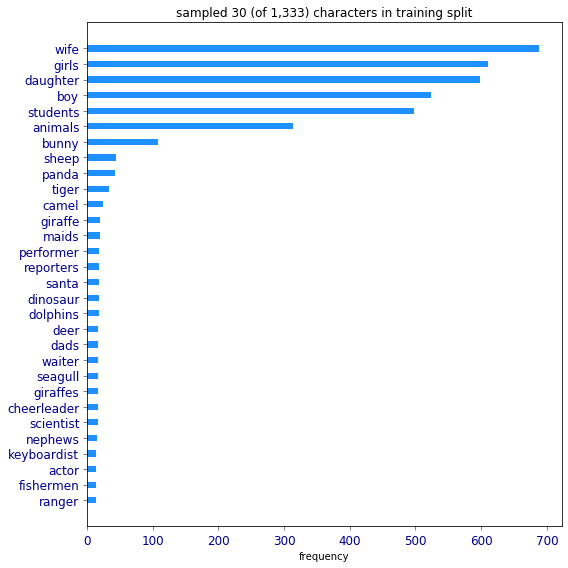

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

hold_characters = [hold[0] for hold in characters_train_frequency_sampled]
hold_characters.reverse()

hold_characters_freq = [hold[1] for hold in characters_train_frequency_sampled]
hold_characters_freq.reverse()

plt.figure(figsize=(8, 8))
plt.barh(hold_characters, 
        hold_characters_freq, 
         color='dodgerblue', align='center', height=0.4)
plt.title(f'sampled 30 (of 1,333) characters in training split')
plt.xlabel('frequency')
plt.tick_params(direction='out', length=4, width=0.5, labelcolor='darkblue',
               grid_color='r', grid_alpha=0.5, labelsize='large')
plt.tight_layout()
plt.savefig('../../resources/plots/sampled_30_char_train.jpg', dpi=300)

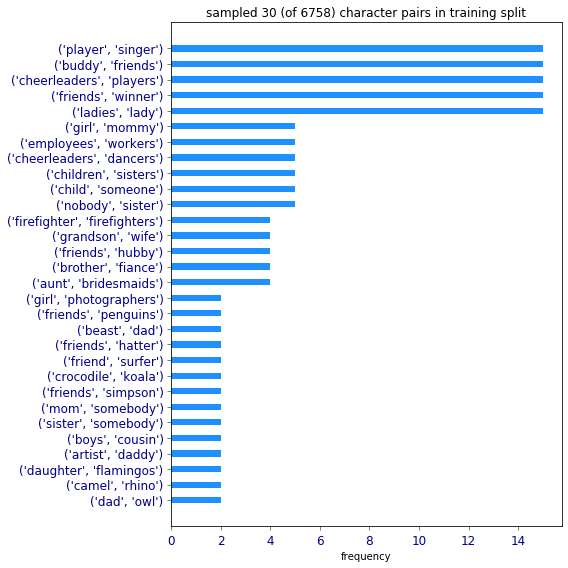

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

hold_character_pairs = [str(hold[0]) for hold in character_pairs_train_frequency_sampled]
hold_character_pairs.reverse()

hold_character_pairs_freq = [hold[1] for hold in character_pairs_train_frequency_sampled]
hold_character_pairs_freq.reverse()

plt.figure(figsize=(8, 8))
plt.barh(hold_character_pairs, 
        hold_character_pairs_freq, 
         color='dodgerblue', align='center', height=0.4)
plt.title(f'sampled 30 (of 6758) character pairs in training split')
plt.xlabel('frequency')
plt.tick_params(direction='out', length=4, width=0.5, labelcolor='darkblue',
               grid_color='r', grid_alpha=0.5, labelsize='large')
plt.tight_layout()
plt.savefig('../../resources/plots/sampled_30_char_pairs_train.jpg', dpi=300)

In [112]:
import json

with open('../../resources/characters_analysis/characters_train.json', mode='w') as file:
    json.dump(characters_train_filtered, file)

file.close()

with open('../../resources/characters_analysis/characters_frequency_train.txt', mode='w') as file:
    file.write('\n'.join([str(hold) for hold in characters_train_frequency]))
    
file.close()

with open('../../resources/characters_analysis/character_pairs_frequency_train.txt', mode='w') as file:
    file.write('\n'.join([str(hold) for hold in character_pairs_train_frequency]))
    
file.close()

print('saved characters-stories mapping as json, characters frequency and respective pair frequencies as txt files!')

saved characters-stories mapping as json, characters frequency and respective pair frequencies as txt files!


### Validation split

In [115]:
characters_val_filtered = filter_characters(characters_val, 'validation')
print(f'\n{len(characters_val_filtered)} validation split stories with more than 2 characters')
characters_val_frequency = characters_frequency(characters_val_filtered)
print(f'\n{len(characters_val_frequency)} distinct characters in filtered validation split')
character_pairs_val_frequency = frequent_pairs(characters_val_filtered)
print(f'\n{len(character_pairs_val_frequency)} pairs in validation split')


validation split:

	40470: ['sister', 'dad']
	40472: ['wife', 'dad']
	40473: ['friends', 'dad']
	40478: ['shoppers', 'friends']
	40485: ['boy', 'boy']

1015 validation split stories with more than 2 characters

387 distinct characters in filtered validation split

1219 pairs in validation split


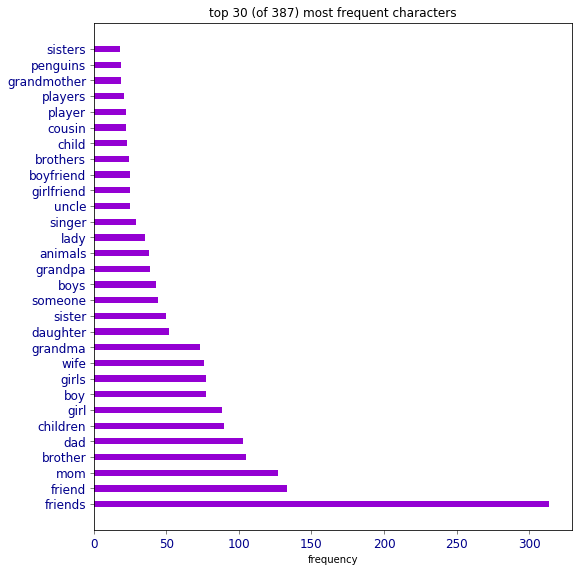

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.barh([hold[0] for hold in characters_val_frequency[:30]], 
        [hold[1] for hold in characters_val_frequency[:30]], 
         color='darkviolet', align='center', height=0.4)
plt.title(f'top 30 (of {len(characters_val_frequency)}) most frequent characters')
plt.xlabel('frequency')
plt.tight_layout()
plt.tick_params(direction='out', length=4, width=0.5, labelcolor='darkblue',
               grid_color='r', grid_alpha=0.5, labelsize='large')
plt.savefig('../../resources/plots/top_30_char_val.jpg')

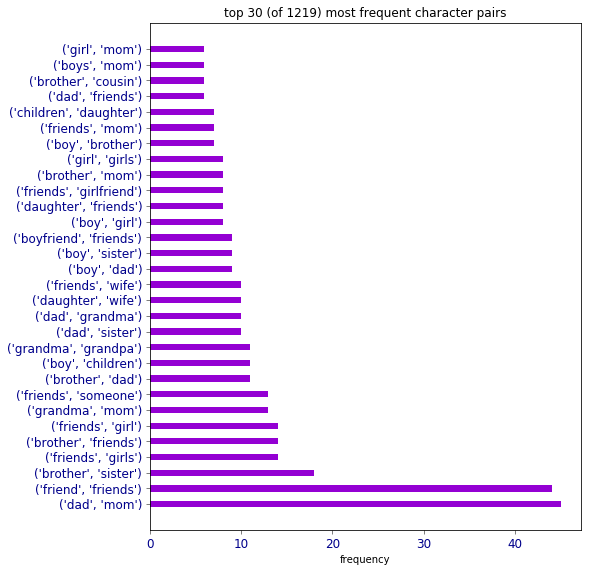

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.barh([str(hold[0]) for hold in character_pairs_val_frequency[:30]], 
        [hold[1] for hold in character_pairs_val_frequency[:30]], 
         color='darkviolet', align='center', height=0.4)
plt.title(f'top 30 (of {len(character_pairs_val_frequency)}) most frequent character pairs')
plt.xlabel('frequency')
plt.tight_layout()
plt.tick_params(direction='out', length=4, width=0.5, labelcolor='darkblue',
               grid_color='r', grid_alpha=0.5, labelsize='large')
plt.savefig('../../resources/plots/top_30_char_pairs_val.jpg')

In [118]:
import json

with open('../../resources/characters_analysis/characters_val.json', mode='w') as file:
    json.dump(characters_val_filtered, file)

file.close()

with open('../../resources/characters_analysis/characters_frequency_val.txt', mode='w') as file:
    file.write('\n'.join([str(hold) for hold in characters_val_frequency]))
    
file.close()

with open('../../resources/characters_analysis/character_pairs_frequency_val.txt', mode='w') as file:
    file.write('\n'.join([str(hold) for hold in character_pairs_val_frequency]))
    
file.close()

print('saved characters-stories mapping as json, characters frequency and respective pair frequencies as txt files!')

saved characters-stories mapping as json, characters frequency and respective pair frequencies as txt files!


### Testing split

In [119]:
characters_test_filtered = filter_characters(characters_test, 'test')
print(f'\n{len(characters_test_filtered)} test split stories with more than 2 characters')
characters_test_frequency = characters_frequency(characters_test_filtered)
print(f'\n{len(characters_test_frequency)} distinct characters in filtered test split')
character_pairs_test_frequency = frequent_pairs(characters_test_filtered)
print(f'\n{len(character_pairs_test_frequency)} pairs in test split')


test split:

	45533: ['merchants', 'merchants']
	45534: ['vendors', 'visitors']
	45536: ['mom', 'daughter', 'animals']
	45542: ['animals', 'children']
	45544: ['attendees', 'attendees']

1376 test split stories with more than 2 characters

466 distinct characters in filtered test split

1440 pairs in test split


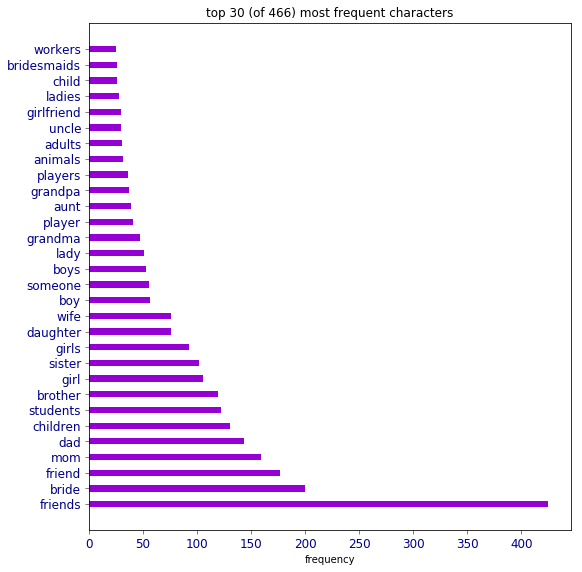

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.barh([hold[0] for hold in characters_test_frequency[:30]], 
        [hold[1] for hold in characters_test_frequency[:30]], 
         color='darkviolet', align='center', height=0.4)
plt.title(f'top 30 (of {len(characters_test_frequency)}) most frequent characters')
plt.xlabel('frequency')
plt.tight_layout()
plt.tick_params(direction='out', length=4, width=0.5, labelcolor='darkblue',
               grid_color='r', grid_alpha=0.5, labelsize='large')
plt.savefig('../../resources/plots/top_30_char_test.jpg')

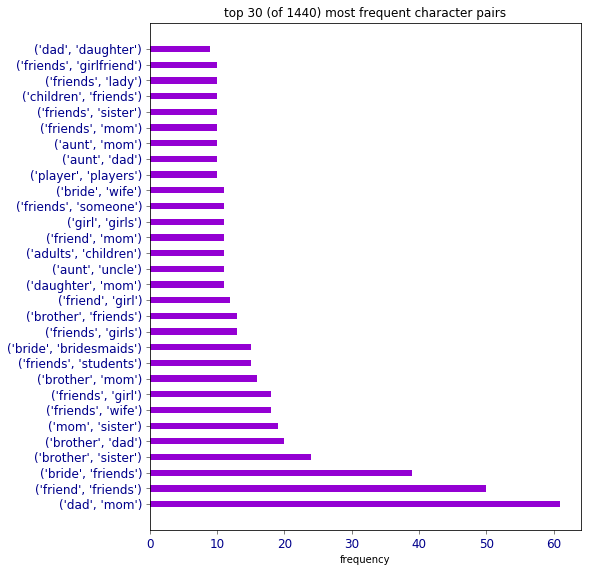

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.barh([str(hold[0]) for hold in character_pairs_test_frequency[:30]], 
        [hold[1] for hold in character_pairs_test_frequency[:30]], 
         color='darkviolet', align='center', height=0.4)
plt.title(f'top 30 (of {len(character_pairs_test_frequency)}) most frequent character pairs')
plt.xlabel('frequency')
plt.tight_layout()
plt.tick_params(direction='out', length=4, width=0.5, labelcolor='darkblue',
               grid_color='r', grid_alpha=0.5, labelsize='large')
plt.savefig('../../resources/plots/top_30_char_pairs_test.jpg')

In [124]:
import json

with open('../../resources/characters_analysis/characters_test.json', mode='w') as file:
    json.dump(characters_test_filtered, file)

file.close()

with open('../../resources/characters_analysis/characters_frequency_test.txt', mode='w') as file:
    file.write('\n'.join([str(hold) for hold in characters_test_frequency]))
    
file.close()

with open('../../resources/characters_analysis/character_pairs_frequency_test.txt', mode='w') as file:
    file.write('\n'.join([str(hold) for hold in character_pairs_test_frequency]))
    
file.close()

print('saved characters-stories mapping as json, characters frequency and respective pair frequencies as txt files!')

saved characters-stories mapping as json, characters frequency and respective pair frequencies as txt files!


## Plan for character relationships

<h3 style='text-decoration: underline;'> Tentative steps: </h3>

1. Retrieve characters from the story (concat'ed descriptions)

2. Retrieve most cooccurring pairs (with the characters from step1) from overall dataset split

3. Get individual character frequencies (of all characters from steps above)

4. Get probabilities (individually or by applying `SoftMax`). Call these tags/semantics!

5. <span style='color: #f44242;'>Apply</span> <span style="color: #41dcf4;">[SCN](https://github.com/zhegan27/Semantic_Compositional_Nets) </span> by considering story features (instead of image features) and tags for decoder

6. **<span style="color: #f4eb41;"> Evaluate? Compare? Report? </span>**